# Fraud Detection - Feature Engineering

In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

## Load Preprocessed Data

In [2]:
df = pd.read_csv("../DATA/processed.csv")
print(f"Initial shape: {df.shape}")
df.head()

Initial shape: (4999997, 20)


,timestamp,sender_account,receiver_account,amount,transaction_type,merchant_category,location,device_used,is_fraud,time_since_last_transaction,spending_deviation_score,velocity_score,geo_anomaly_score,payment_channel,ip_address,device_hash,hour,day,day_of_week,month
0,2023-01-01 00:09:26.241974,158871,89037,12.25,2,1,1,0,0,-7559.966086,-0.32,2.0,0.96,1,4781010,3735305,0.0,1.0,6.0,1.0
1,2023-01-01 00:11:36.452582,376957,4992,1347.27,0,6,5,1,0,1.525799,-0.68,5.0,0.67,1,232516,550645,0.0,1.0,6.0,1.0
2,2023-01-01 00:12:48.028557,727819,491398,20.79,1,6,6,3,0,-4568.663237,0.14,8.0,0.42,3,2541431,3740925,0.0,1.0,6.0,1.0
3,2023-01-01 00:21:19.560899,545869,270273,740.73,0,7,0,1,0,1.525799,-2.09,20.0,0.86,1,609531,1437485,0.0,1.0,6.0,1.0
4,2023-01-01 00:23:15.259766,880977,66830,228.67,0,1,1,1,0,-48.738700,0.16,18.0,0.82,1,736628,1085200,0.0,1.0,6.0,1.0


In [3]:
df["timestamp"] = pd.to_datetime(df["timestamp"])

## Amount-Based Features

In [4]:
## Amount features
df["amount_per_velocity"] = df["amount"] / (df["velocity_score"] + 1)
df["amount_log"] = np.log1p(df["amount"])
df["amount_to_avg_ratio"] = df["amount"] / df.groupby("sender_account")["amount"].transform("mean")

print("Amount-based features created:")
print(df[['amount', 'amount_per_velocity', 'amount_log', 'amount_to_avg_ratio']].head())

Amount-based features created:
    amount  amount_per_velocity  amount_log  amount_to_avg_ratio
0    12.25             4.083333    2.583998             0.047631
1  1347.27           224.545000    7.206578             3.648828
2    20.79             2.310000    3.081451             0.121930
3   740.73            35.272857    6.608985             1.993156
4   228.67            12.035263    5.436643             0.343055


## Frequency Features

In [5]:
## Frequency features
df["transaction_per_day"] = df.groupby(["sender_account","day"])["amount"].transform("count")
df["transaction_gap"] = df.groupby("sender_account")["timestamp"].diff().dt.total_seconds().fillna(0)

print("Frequency features created:")
print(df[['sender_account', 'transaction_per_day', 'transaction_gap']].head())

Frequency features created:
   sender_account  transaction_per_day  transaction_gap
0          158871                    2              0.0
1          376957                    1              0.0
2          727819                    1              0.0
3          545869                    1              0.0
4          880977                    1              0.0


## Risk Features (Behavioral Flags)

In [6]:
## Risk features
df["is_night_transaction"] = df["hour"].between(18,24).astype(int)
df["is_weekend"] = df["day_of_week"].isin([6,7]).astype(int)
df["is_self_transfer"] = (df["sender_account"] == df["receiver_account"]).astype(int)

print("Risk features created:")
print(df[['hour', 'is_night_transaction', 'day_of_week', 'is_weekend', 'is_self_transfer']].describe())

Risk features created:
               hour  is_night_transaction   day_of_week    is_weekend  \
count  4.999997e+06          4.999997e+06  4.999997e+06  4.999997e+06   
mean   1.149665e+01          2.499819e-01  2.999544e+00  1.438627e-01   
std    6.921329e+00          4.330023e-01  2.003172e+00  3.509505e-01   
min    0.000000e+00          0.000000e+00  0.000000e+00  0.000000e+00   
25%    5.000000e+00          0.000000e+00  1.000000e+00  0.000000e+00   
50%    1.100000e+01          0.000000e+00  3.000000e+00  0.000000e+00   
75%    1.700000e+01          0.000000e+00  5.000000e+00  0.000000e+00   
max    2.300000e+01          1.000000e+00  6.000000e+00  1.000000e+00   

       is_self_transfer  
count      4.999997e+06  
mean       1.200001e-06  
std        1.095445e-03  
min        0.000000e+00  
25%        0.000000e+00  
50%        0.000000e+00  
75%        0.000000e+00  
max        1.000000e+00  


## Network Features

In [7]:
## Network features
df["sender_degree"] = df.groupby("sender_account")["receiver_account"].transform("nunique")
df["receiver_degree"] = df.groupby("receiver_account")["sender_account"].transform("nunique")
df["sender_total_transaction"] = df.groupby("sender_account")["amount"].transform("count")
df["receiver_total_transaction"] = df.groupby("receiver_account")["amount"].transform("count")

print("Network features created:")
print(df[['sender_account', 'sender_degree', 'sender_total_transaction', 'receiver_degree', 'receiver_total_transaction']].head())

Network features created:
   sender_account  sender_degree  sender_total_transaction  receiver_degree  \
0          158871              7                         7                5   
1          376957             11                        11                5   
2          727819              5                         5                8   
3          545869              6                         6                4   
4          880977              6                         6                8   

   receiver_total_transaction  
0                           5  
1                           5  
2                           8  
3                           4  
4                           8  


## Aggregation Features

In [8]:
## Aggregation features
df["sender_avg_amount"] = df.groupby("sender_account")["amount"].transform("mean")
df["sender_std_amount"] = df.groupby("sender_account")["amount"].transform("std").fillna(0)

print("Aggregation features created:")
print(df[['sender_account', 'amount', 'sender_avg_amount', 'sender_std_amount']].head())

Aggregation features created:
   sender_account   amount  sender_avg_amount  sender_std_amount
0          158871    12.25         257.182857         252.287044
1          376957  1347.27         369.233636         473.217498
2          727819    20.79         170.508000         189.434766
3          545869   740.73         371.636667         411.455138
4          880977   228.67         666.570000         581.488102


## Fraud Features

In [9]:
## Fraud features
df["sender_fraud_transaction"] = df.groupby("sender_account")["is_fraud"].transform("sum")
df["receiver_fraud_transaction"] = df.groupby("receiver_account")["is_fraud"].transform("sum")

df["sender_fraud_percentage"] = (df["sender_fraud_transaction"]*100/df["sender_total_transaction"]).round(2)
df["receiver_fraud_percentage"] = (df["receiver_fraud_transaction"]*100/df["receiver_total_transaction"]).round(2)

df[["sender_fraud_percentage", "receiver_fraud_percentage"]] = df[["sender_fraud_percentage", "receiver_fraud_percentage"]].fillna(0)

print("Fraud features created:")
print(df[['sender_account', 'sender_fraud_transaction', 'sender_fraud_percentage', 'receiver_fraud_transaction', 'receiver_fraud_percentage']].head())

Fraud features created:
   sender_account  sender_fraud_transaction  sender_fraud_percentage  \
0          158871                         0                      0.0   
1          376957                         0                      0.0   
2          727819                         0                      0.0   
3          545869                         0                      0.0   
4          880977                         0                      0.0   

   receiver_fraud_transaction  receiver_fraud_percentage  
0                           0                        0.0  
1                           1                       20.0  
2                           1                       12.5  
3                           0                        0.0  
4                           0                        0.0  


## Other Features

In [10]:
## Others
df["deviation_squared"] = df["spending_deviation_score"] ** 2

print("Other features created:")
print(df[['spending_deviation_score', 'deviation_squared']].head())

Other features created:
   spending_deviation_score  deviation_squared
0                     -0.32             0.1024
1                     -0.68             0.4624
2                      0.14             0.0196
3                     -2.09             4.3681
4                      0.16             0.0256


## Clean Up Unnecessary Columns

In [11]:
# Drop columns that shouldn't be in the final feature set
columns_to_drop = ['Unnamed: 0', 'timestamp']
df.drop(columns=[col for col in columns_to_drop if col in df.columns], inplace=True)

print(f"Shape after cleanup: {df.shape}")

Shape after cleanup: (4999997, 38)


## Feature Summary

In [12]:
print("\nFinal Feature Set:")
print("=" * 60)
print(f"Total features: {len(df.columns)}")
print(f"Total rows: {len(df)}")
print("\nFeature names:")
for i, col in enumerate(df.columns, 1):
    print(f"{i:2d}. {col}")


Final Feature Set:
Total features: 38
Total rows: 4999997

Feature names:
 1. sender_account
 2. receiver_account
 3. amount
 4. transaction_type
 5. merchant_category
 6. location
 7. device_used
 8. is_fraud
 9. time_since_last_transaction
10. spending_deviation_score
11. velocity_score
12. geo_anomaly_score
13. payment_channel
14. ip_address
15. device_hash
16. hour
17. day
18. day_of_week
19. month
20. amount_per_velocity
21. amount_log
22. amount_to_avg_ratio
23. transaction_per_day
24. transaction_gap
25. is_night_transaction
26. is_weekend
27. is_self_transfer
28. sender_degree
29. receiver_degree
30. sender_total_transaction
31. receiver_total_transaction
32. sender_avg_amount
33. sender_std_amount
34. sender_fraud_transaction
35. receiver_fraud_transaction
36. sender_fraud_percentage
37. receiver_fraud_percentage
38. deviation_squared


In [13]:
# Display statistics for all features
df.describe()

,sender_account,receiver_account,amount,transaction_type,merchant_category,location,device_used,is_fraud,time_since_last_transaction,spending_deviation_score,...,receiver_degree,sender_total_transaction,receiver_total_transaction,sender_avg_amount,sender_std_amount,sender_fraud_transaction,receiver_fraud_transaction,sender_fraud_percentage,receiver_fraud_percentage,deviation_squared
count,4.999997e+06,4.999997e+06,4.999997e+06,4.999997e+06,4.999997e+06,4.999997e+06,4.999997e+06,4.999997e+06,4.999997e+06,4.999997e+06,...,4.999997e+06,4.999997e+06,4.999997e+06,4.999997e+06,4.999997e+06,4.999997e+06,4.999997e+06,4.999997e+06,4.999997e+06,4.999997e+06
mean,4.483520e+05,4.483735e+05,3.589344e+02,1.499402e+00,3.500390e+00,3.500437e+00,1.499932e+00,3.591062e-02,1.523688e+00,-3.882662e-04,...,6.554718e+00,6.557000e+00,6.554739e+00,3.589344e+02,4.167305e+02,2.432135e-01,2.353945e-01,3.591213e+00,3.591206e+00,1.001614e+00
std,2.587920e+05,2.588069e+05,4.699334e+02,1.117896e+00,2.291134e+00,2.291127e+00,1.117982e+00,1.860673e-01,3.240097e+03,1.000807e+00,...,2.357503e+00,2.360782e+00,2.357512e+00,1.990092e+02,2.152144e+02,4.935771e-01,4.831025e-01,7.628800e+00,7.874178e+00,1.417988e+00
min,0.000000e+00,0.000000e+00,1.000000e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-8.777814e+03,-5.260000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.242590e+05,2.242040e+05,2.657000e+01,0.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,0.000000e+00,-1.920275e+03,-6.800000e-01,...,5.000000e+00,5.000000e+00,5.000000e+00,2.133022e+02,2.449691e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.024000e-01
50%,4.483290e+05,4.484920e+05,1.386700e+02,1.000000e+00,4.000000e+00,4.000000e+00,1.000000e+00,0.000000e+00,1.525799e+00,0.000000e+00,...,6.000000e+00,6.000000e+00,6.000000e+00,3.364667e+02,4.192570e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.489000e-01
75%,6.725690e+05,6.724110e+05,5.038900e+02,2.000000e+00,5.000000e+00,6.000000e+00,3.000000e+00,0.000000e+00,1.923793e+03,6.700000e-01,...,8.000000e+00,8.000000e+00,8.000000e+00,4.745957e+02,5.675710e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.322500e+00
max,8.965120e+05,8.966380e+05,3.520570e+03,3.000000e+00,7.000000e+00,7.000000e+00,3.000000e+00,1.000000e+00,8.757758e+03,5.020000e+00,...,2.300000e+01,2.000000e+01,2.300000e+01,2.817380e+03,2.022764e+03,7.000000e+00,5.000000e+00,7.500000e+01,1.000000e+02,2.766760e+01


In [14]:
# Check for any missing values introduced during feature engineering
print("\nMissing values check:")
missing = df.isna().sum()
if missing.sum() > 0:
    print(missing[missing > 0])
else:
    print("No missing values")


Missing values check:
No missing values


In [15]:
df.dropna(subset=['hour', 'day', 'day_of_week', 'month'], inplace=True)

In [16]:
# Check for any missing values introduced during feature engineering
print("\nMissing values check:")
missing = df.isna().sum()
if missing.sum() > 0:
    print(missing[missing > 0])
else:
    print("No missing values")


Missing values check:
No missing values


In [17]:
# Display sample of engineered features
df.head(10)

,sender_account,receiver_account,amount,transaction_type,merchant_category,location,device_used,is_fraud,time_since_last_transaction,spending_deviation_score,...,receiver_degree,sender_total_transaction,receiver_total_transaction,sender_avg_amount,sender_std_amount,sender_fraud_transaction,receiver_fraud_transaction,sender_fraud_percentage,receiver_fraud_percentage,deviation_squared
0,158871,89037,12.25,2,1,1,0,0,-7559.966086,-0.32,...,5,7,5,257.182857,252.287044,0,0,0.00,0.0,0.1024
1,376957,4992,1347.27,0,6,5,1,0,1.525799,-0.68,...,5,11,5,369.233636,473.217498,0,1,0.00,20.0,0.4624
2,727819,491398,20.79,1,6,6,3,0,-4568.663237,0.14,...,8,5,8,170.508000,189.434766,0,1,0.00,12.5,0.0196
3,545869,270273,740.73,0,7,0,1,0,1.525799,-2.09,...,4,6,4,371.636667,411.455138,0,0,0.00,0.0,4.3681
4,880977,66830,228.67,0,1,1,1,0,-48.738700,0.16,...,8,6,8,666.570000,581.488102,0,0,0.00,0.0,0.0256
5,892085,284721,1647.18,0,5,3,0,0,-3791.283444,1.01,...,8,5,8,736.628000,653.912048,0,0,0.00,0.0,1.0201
6,516258,30107,10.26,2,7,7,2,0,1.525799,-0.19,...,6,3,6,156.620000,246.632930,1,0,33.33,0.0,0.0361
7,552505,676226,1626.52,0,1,0,0,0,-7478.288218,-0.63,...,7,10,7,771.009000,876.144935,0,0,0.00,0.0,0.3969
8,186345,633891,2107.20,0,5,0,3,0,-2816.832554,-0.03,...,8,8,8,1163.758750,692.818841,0,0,0.00,0.0,0.0009
9,453962,378964,6.65,1,2,6,1,0,-1373.455542,-0.25,...,2,10,2,220.216000,362.922138,0,0,0.00,0.0,0.0625


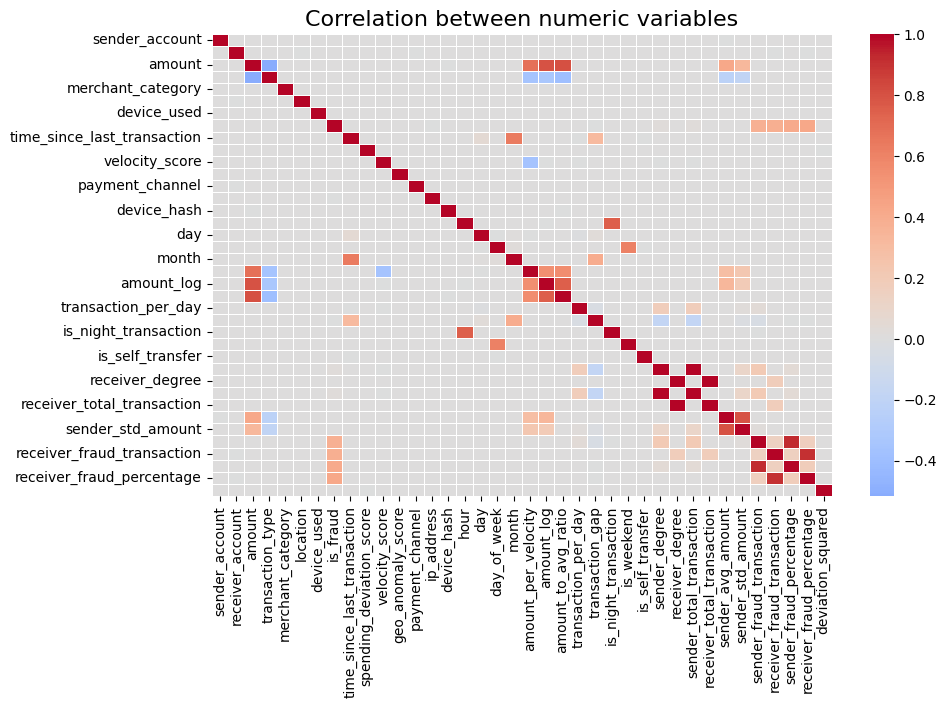

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

correlation_matrix = df.corr()
plt.figure(figsize=(10,6))
sns.heatmap(correlation_matrix,annot=False,cmap='coolwarm',center=0,linewidths=0.5,cbar=True)
plt.title("Correlation between numeric variables",fontsize=16)
plt.show()

## Save Feature-Engineered Data

In [19]:
# Save the feature-engineered data
output_path = "../DATA/feature_engineering.csv"
df.to_csv(output_path, index=False)
print(f"\nFeature-engineered data saved to: {output_path}")
print(f"Final shape: {df.shape}")


Feature-engineered data saved to: ../DATA/feature_engineering.csv
Final shape: (4999997, 38)
